In [160]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [161]:
#!/usr/bin/python
import itertools
import os
from susipop import filter
from susipop import reader
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import sys 
import pandas as pd
from IPython.html.widgets import FloatProgress
from IPython.display import display
import ipywidgets as widgets
%matplotlib notebook

In [162]:
#phivals = [float(i)/100.0 for i in sys.argv[1:]]
phivals = [0.4, 0.45, 0.5, 0.54, 0.55, 0.56]
def get_folder_list():
    f = next(os.walk('.'))[1]
    return f

def sort_data(x,y):
    lists = sorted(itertools.izip(*[x, y]))
    new_x, new_y = list(itertools.izip(*lists))
    return new_x, new_y

In [163]:
folders = get_folder_list()

db = dict()

for phi in phivals:
    db[phi] = [[],[],[]]

f = FloatProgress(min=0, max=100)
display(f)
L = widgets.Label("")
display(L)
progress = widgets.Label("")
display(progress)

for num,folder in enumerate(np.sort(folders[:])):
    try:
        f.value = float(num+1)/len(folders[:])*100
        L.value = folder
        exp = reader.DataSet(folder, fluid=False, particles=True)
        exp.LoadState(exp.tlist[-1])
        max_strain = float(exp.t)*exp.shearrate*exp.dt
        n = len(exp.tlist[2:])
#         if max_strain >= 2.0:
#             n_last_strain = n-int(float(n)/max_strain)
#         elif max_strain >= 3.0:
#             n_last_strain = n-int(float(n)/max_strain)*2
#         elif max_strain >= 4.0:
#             n_last_strain = n-int(float(n)/max_strain)*3
#         else:
#             n_last_strain = -10

        if max_strain >= 1.0:
            n_last_strain = int(float(n)/max_strain)
        else:
            n_last_strain = -10
            
        viscosity_file = pd.read_csv(folder+"/result/nu_t.dat")
        viscosity = np.asarray(viscosity_file[viscosity_file.columns[2]])
        time = viscosity_file[viscosity_file.columns[0]]
#         print folder 
#         print exp.tlist[2:] - time[:]
#         if len(exp.tlist) > 40:
        if len(exp.tlist)>20:
            for i,t in enumerate(exp.tlist[n_last_strain:]):
                exp.LoadState(t)
                progress.value = str(int(float(i)/(len(exp.tlist)*(1-.9))*100))+"%"
                t_ = np.where(time == t)[0]
                if len(t_) == 1: #avoiding empty arrays
                    Shearstress = float(exp.shearrate)*viscosity[t_]
                    Shearrate   = exp.shearrate
                    #number of particles in friction
                    num_part_fric = len(np.where(np.asarray([np.linalg.norm(j) for j in exp.particles.Sshear_fric])!= 0)[0]) 
                    percent_part_fric = float(num_part_fric)/float(exp.npart)*100.0
                    #print folder,'\t', percent_part_fric
                    phi = exp.config['material']['particles']['0']['phi']
                    db[phi][0].append(Shearrate)
                    db[phi][1].append(Shearstress)
                    db[phi][2].append(percent_part_fric)
        else:
            print "skipped "+folder, " ----- ", len(exp.tlist), "datapoints available"
            continue
            
    except Exception as e: 
        print folder, str(e)
        continue
        

.ipynb_checkpoints [Errno 2] No such file or directory: '.ipynb_checkpoints/config.json'
backup [Errno 2] No such file or directory: 'backup/config.json'
rhor1_phi40_yd1.0 [Errno 2] No such file or directory: 'rhor1_phi40_yd1.0/sample/info.json'
rhor1_phi40_yd30.0 
skipped rhor1_phi40_yd50.0  -----  19 datapoints available
rhor1_phi40_yd70.0 
rhor1_phi45_yd1.0 [Errno 2] No such file or directory: 'rhor1_phi45_yd1.0/sample/info.json'
rhor1_phi45_yd30.0 
rhor1_phi45_yd600.0 
rhor1_phi45_yd70.0 File rhor1_phi45_yd70.0/result/nu_t.dat does not exist
skipped rhor1_phi50_yd10.0  -----  12 datapoints available
skipped rhor1_phi50_yd100.0  -----  6 datapoints available


<IPython.core.display.Javascript object>


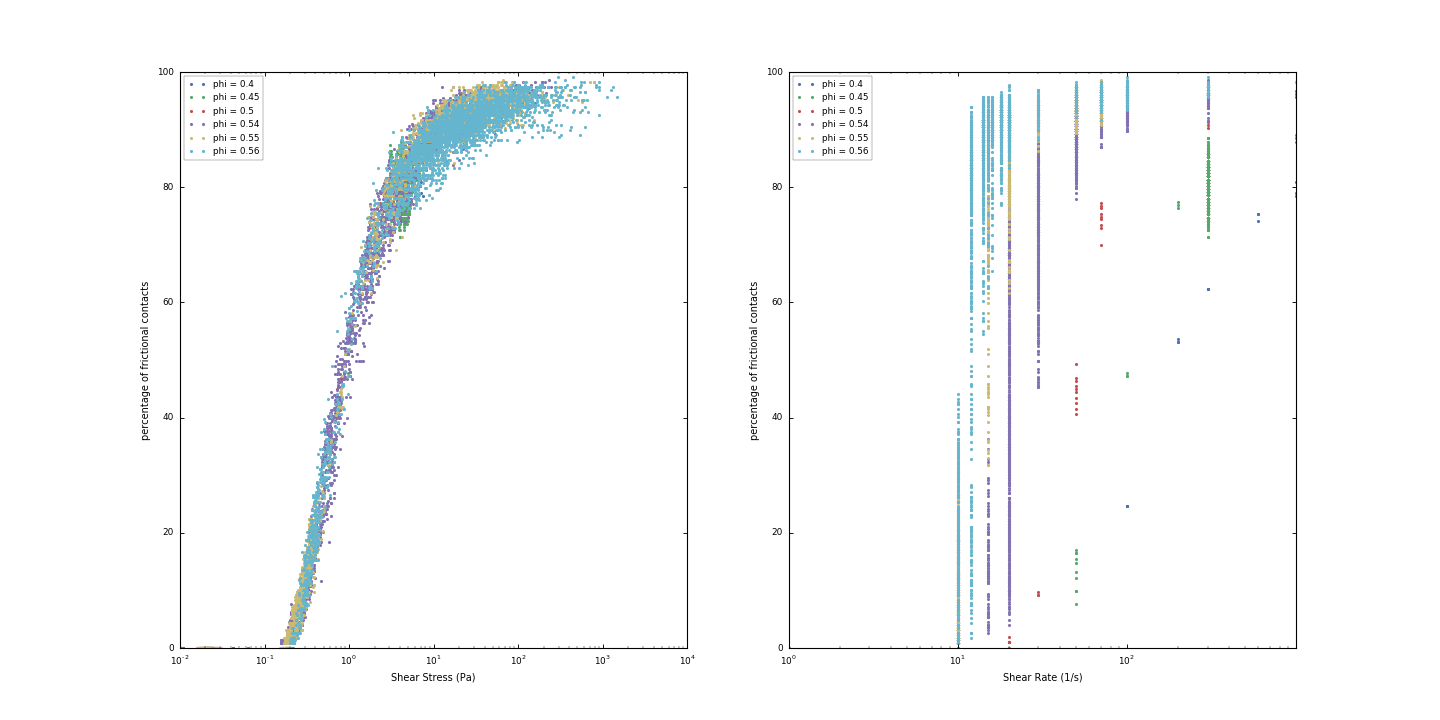

In [164]:
plt.style.use('seaborn-deep')

plt.figure(figsize=[18,9])
plt.subplot(1,2,1)
#for phi in phivals:
phivals = [0.4,0.45,0.5,0.54,0.55,0.56]
for phi in phivals:    
    plt.xscale('log')
    plt.xlabel('Shear Stress (Pa)')
    #plt.xlim([0,1000.0])
    plt.ylabel('percentage of frictional contacts')
    data = np.asarray([db[phi][0],db[phi][1], db[phi][2]])
    plt.plot(data[1], data[2],'.',label = "phi = "+str(phi))    
    plt.legend(loc = 'upper left')
#plt.figure(figsize=[10,10])
plt.subplot(1,2,2)
for phi in phivals:
    plt.xscale('log')
    plt.xlabel('Shear Rate (1/s)')
    #plt.xlim([0,1000.0])
    plt.ylabel('percentage of frictional contacts')
    data = np.asarray([db[phi][0],db[phi][1], db[phi][2]])
    plt.plot(data[0], data[2],'.',label = "phi = "+str(phi))    
    plt.legend(loc = 'upper left')
plt.savefig('frictional_contact_vs_shearstress_and_shearrate')

<IPython.core.display.Javascript object>


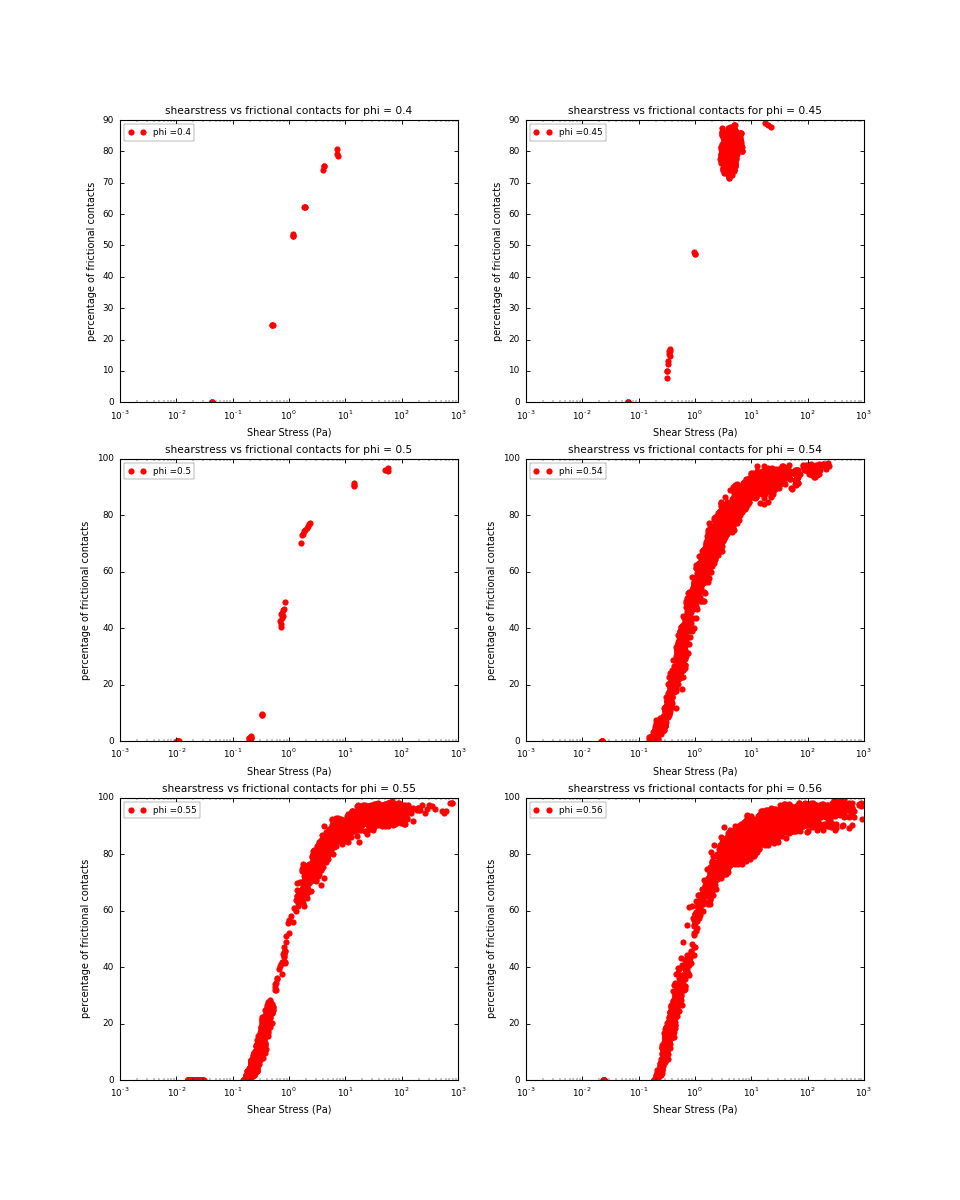

In [165]:
plt.figure(figsize=[12,15])
for i,p in enumerate(np.sort(db.keys())):
    plt.subplot(len(db.keys())/2,2,i+1)
    plt.plot(db[p][1],db[p][2],'ro',label="phi ="+str(p))
    plt.xlim([1e-3,1e3])
    plt.xscale('log')
    plt.xlabel('Shear Stress (Pa)')
    plt.ylabel('percentage of frictional contacts')
    plt.title("shearstress vs frictional contacts for phi = "+str(p))
    plt.legend(loc='upper left')
plt.savefig('frictional_contact_vs_shearstress_individual_phi')

<IPython.core.display.Javascript object>


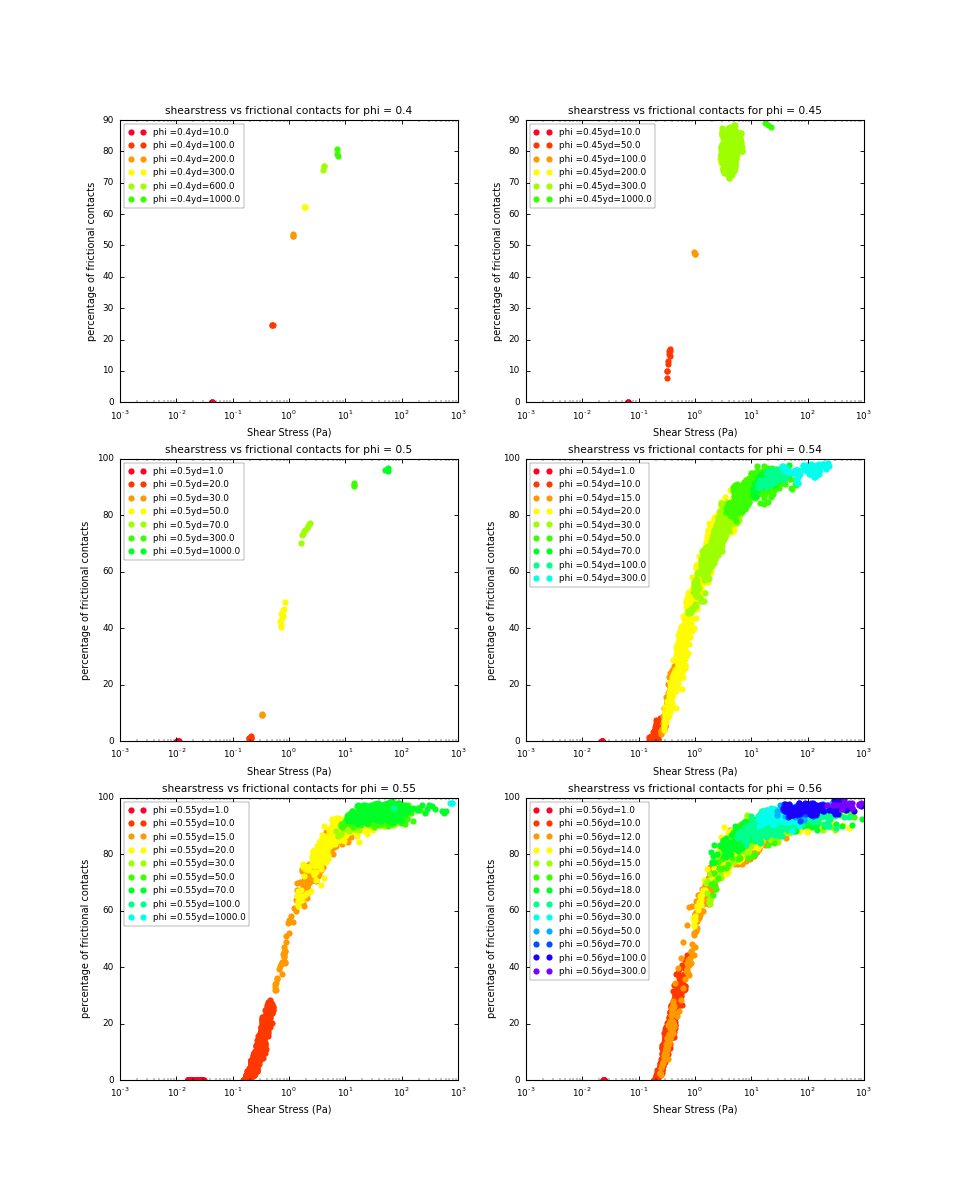

In [166]:
from collections import OrderedDict
import matplotlib.pyplot as plt

NUM_COLORS = 14

cm = plt.get_cmap('gist_rainbow')

fig = plt.figure(figsize=[12,15])
for i,p in enumerate(np.sort(db.keys())):
    db[p] = np.asarray(db[p])
    ax = fig.add_subplot(len(db.keys())/2,2,i+1)
    ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    for s in np.unique(db[p][0]):
        idx = np.where(db[p][0]==s)[0]
        if len(idx) >= 1 :
            plt.plot(db[p][1][idx],db[p][2][idx],'o',label="phi ="+str(p)+"yd="+str(round(s)))
            plt.xlim([1e-3,1e3])
            plt.xscale('log')
            plt.xlabel('Shear Stress (Pa)')
            plt.ylabel('percentage of frictional contacts')
            plt.title("shearstress vs frictional contacts for phi = "+str(p))
            plt.legend(loc='upper left')
plt.savefig('frictional_contact_vs_shearstress_individual_phi')

<IPython.core.display.Javascript object>


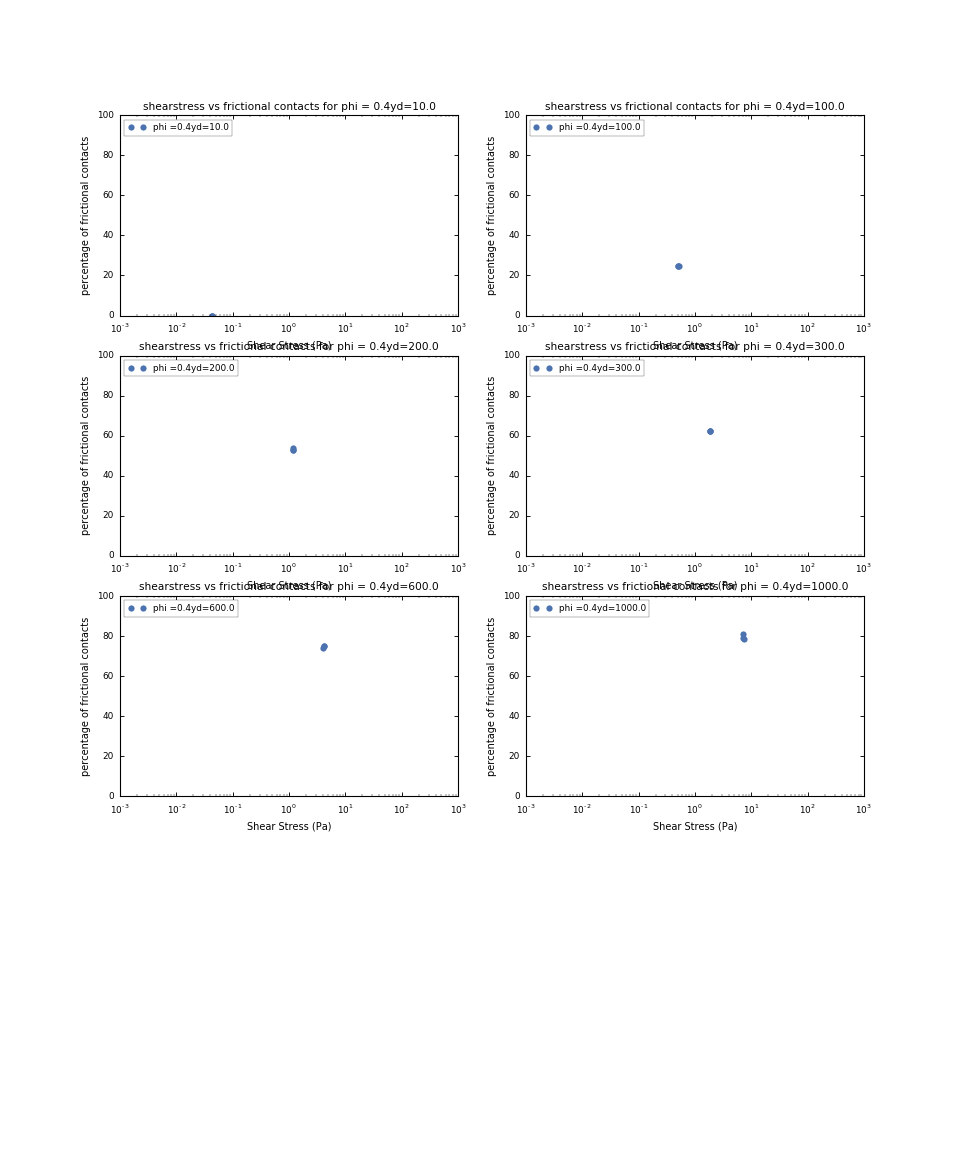

<IPython.core.display.Javascript object>


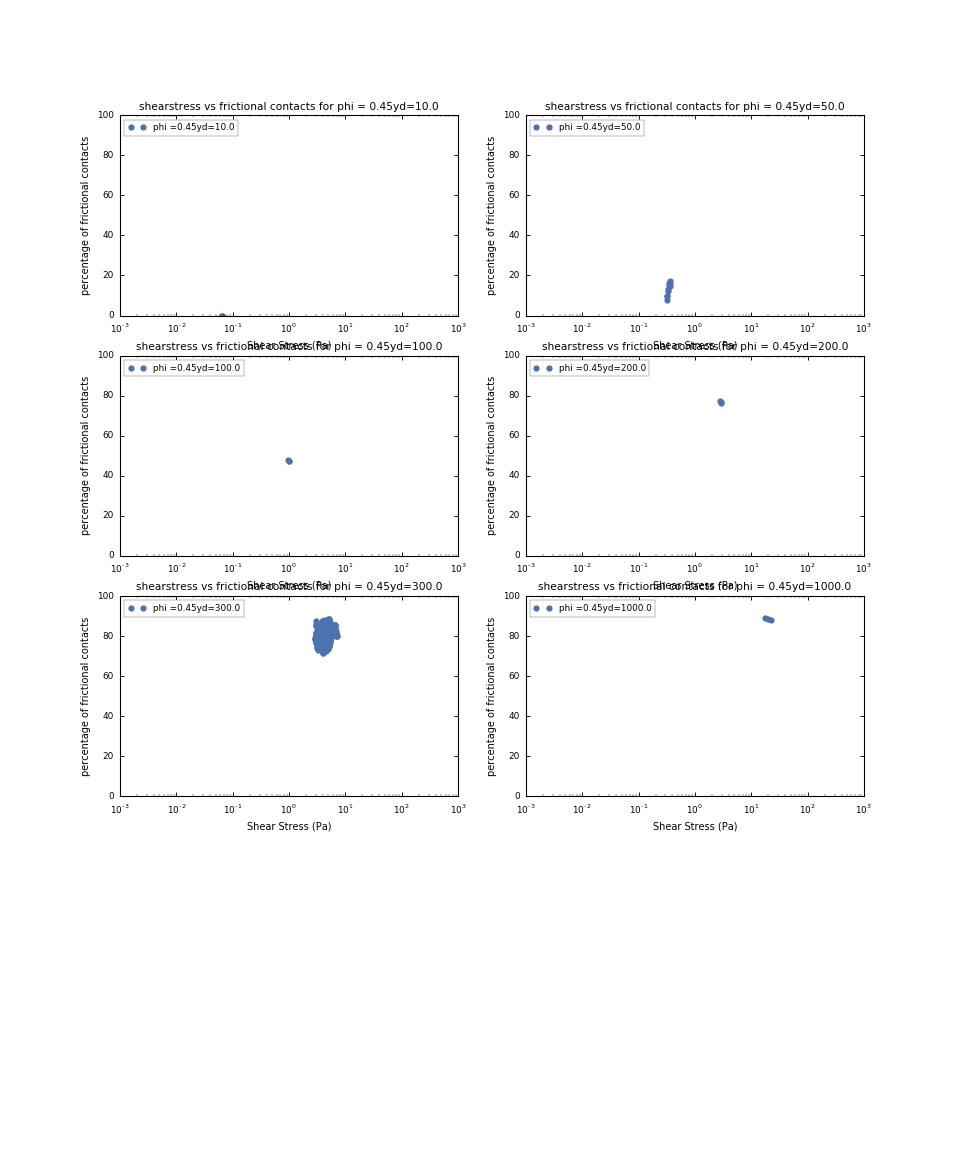

<IPython.core.display.Javascript object>


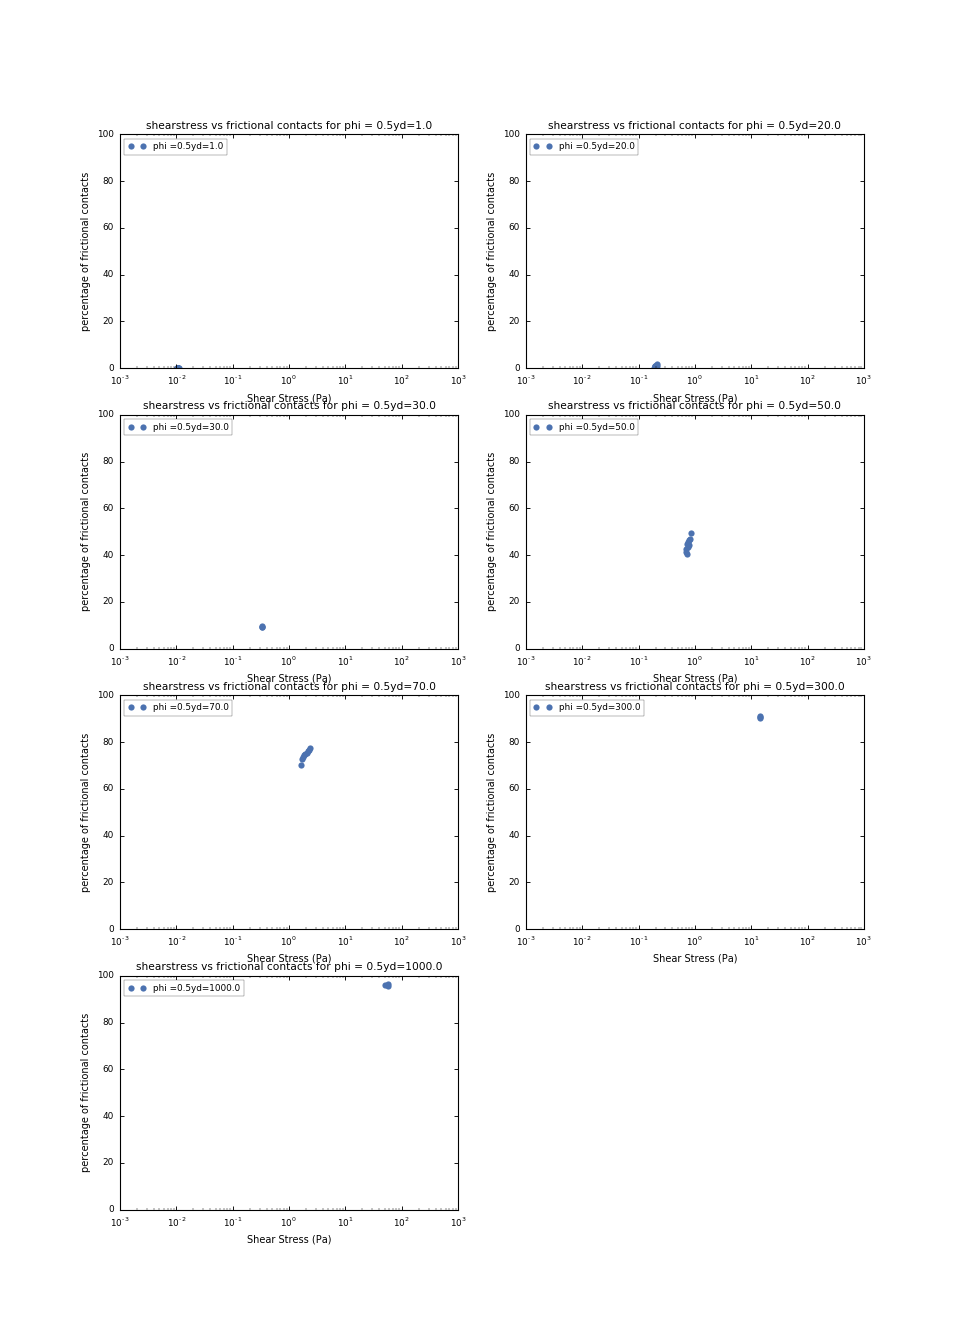

<IPython.core.display.Javascript object>


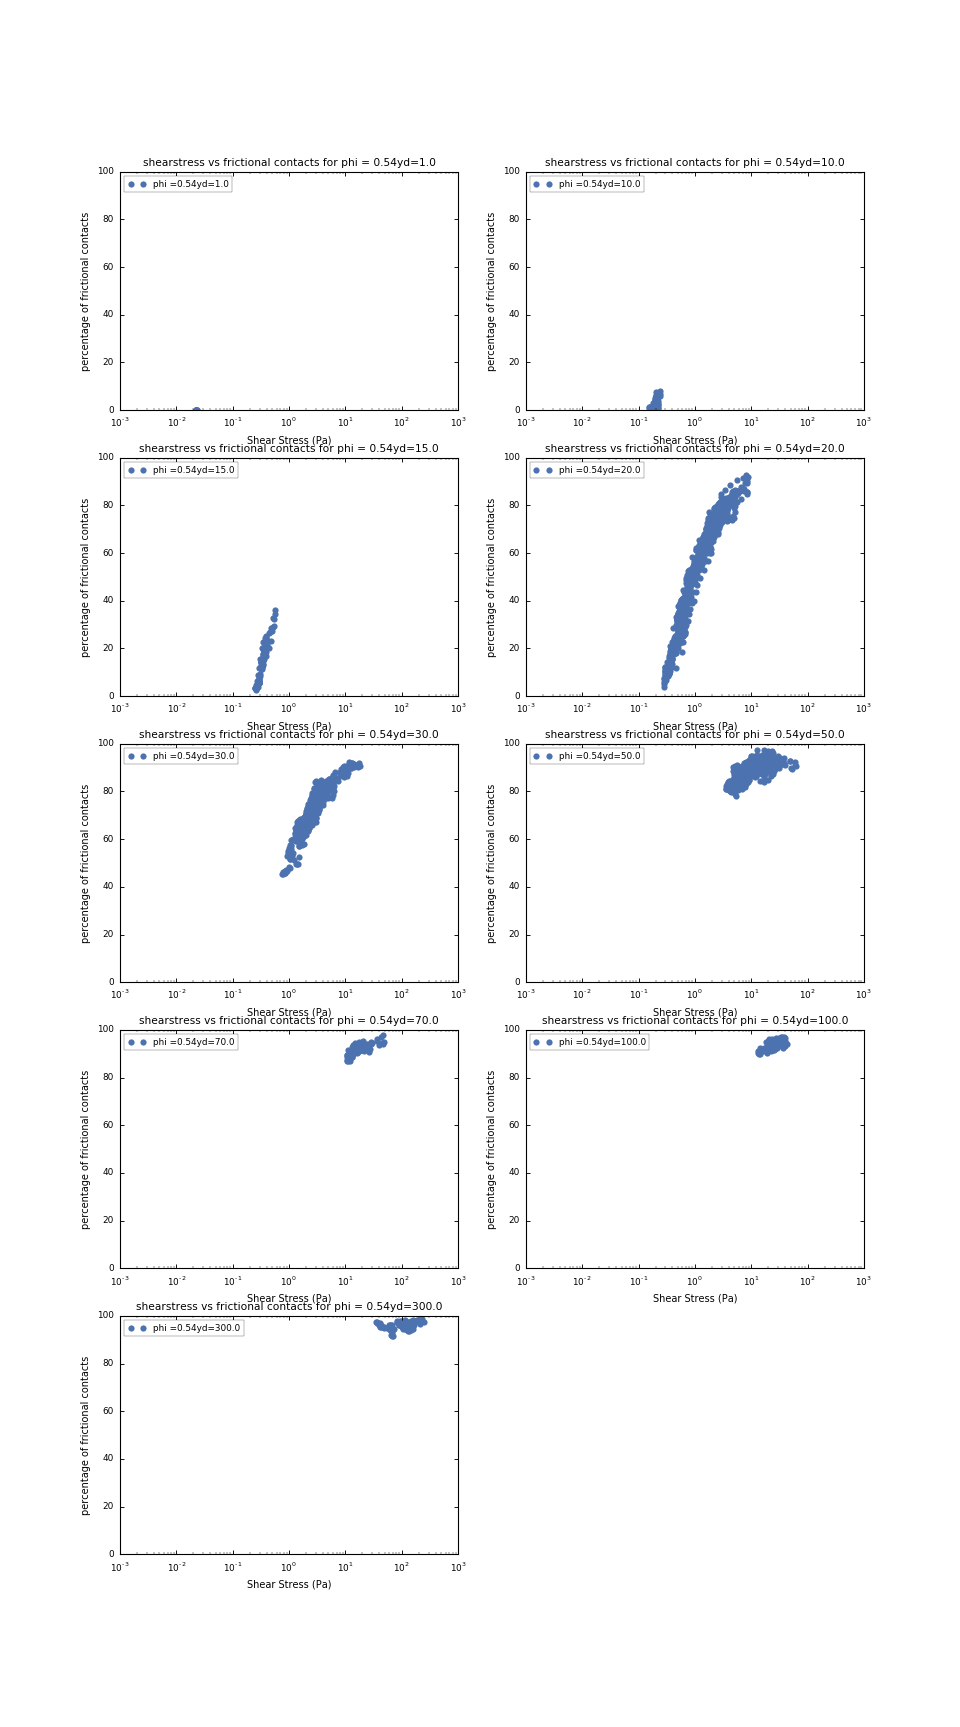

<IPython.core.display.Javascript object>


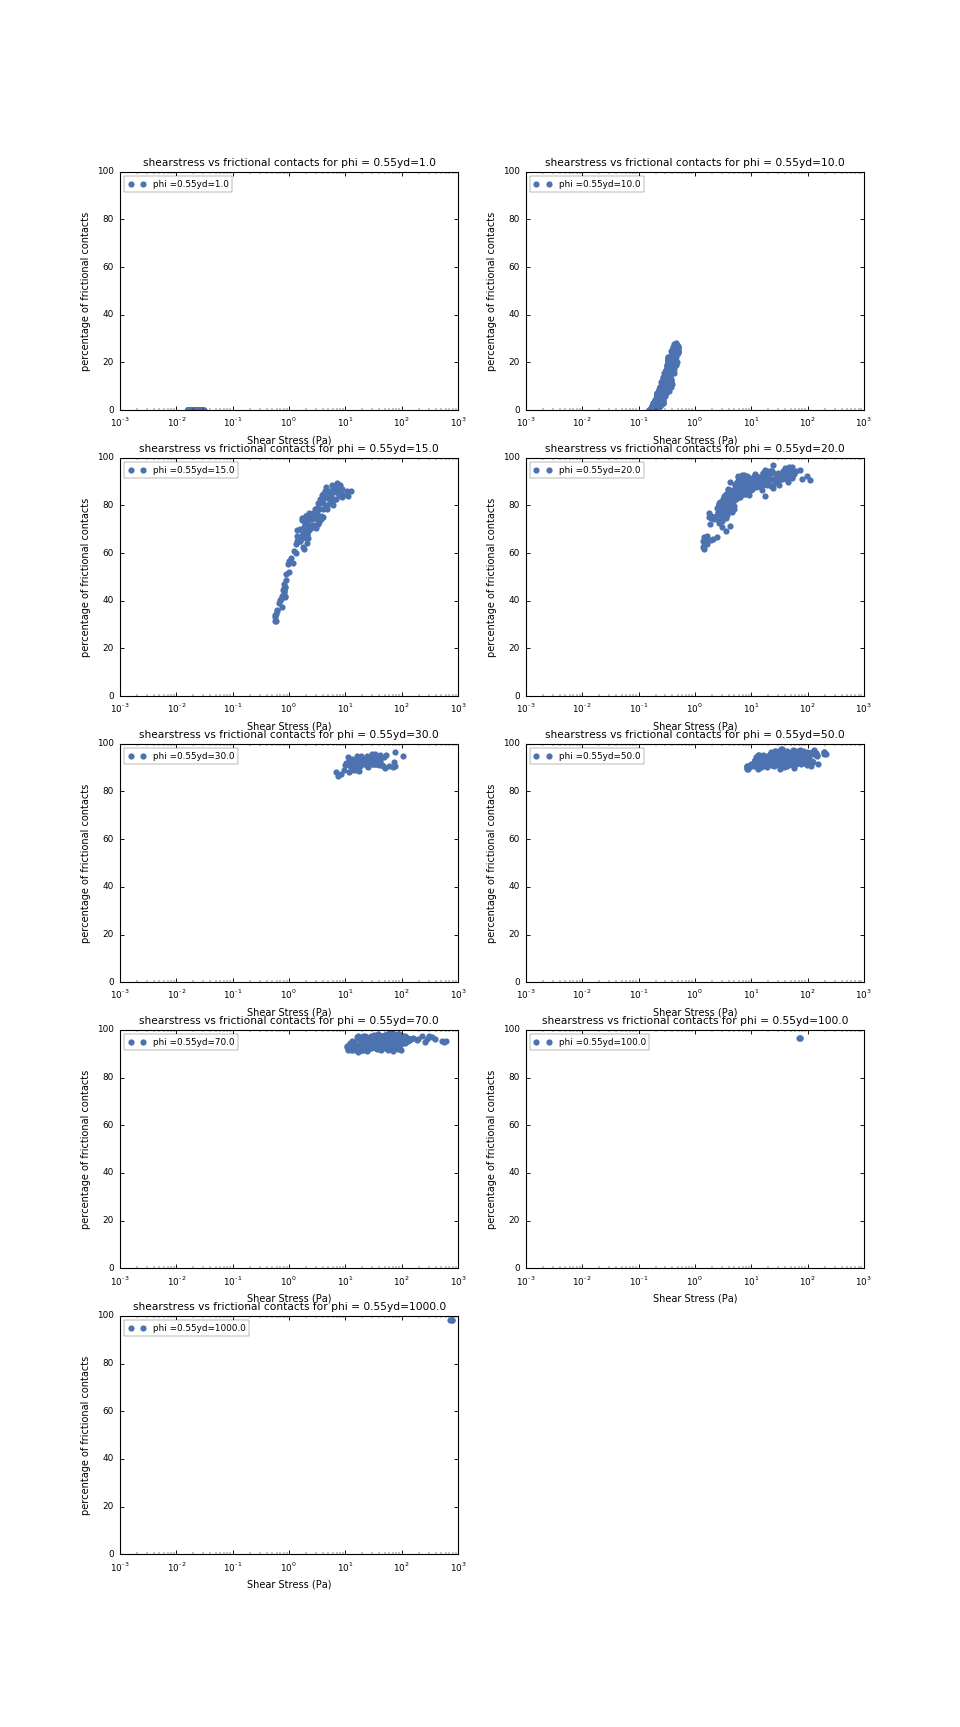

<IPython.core.display.Javascript object>


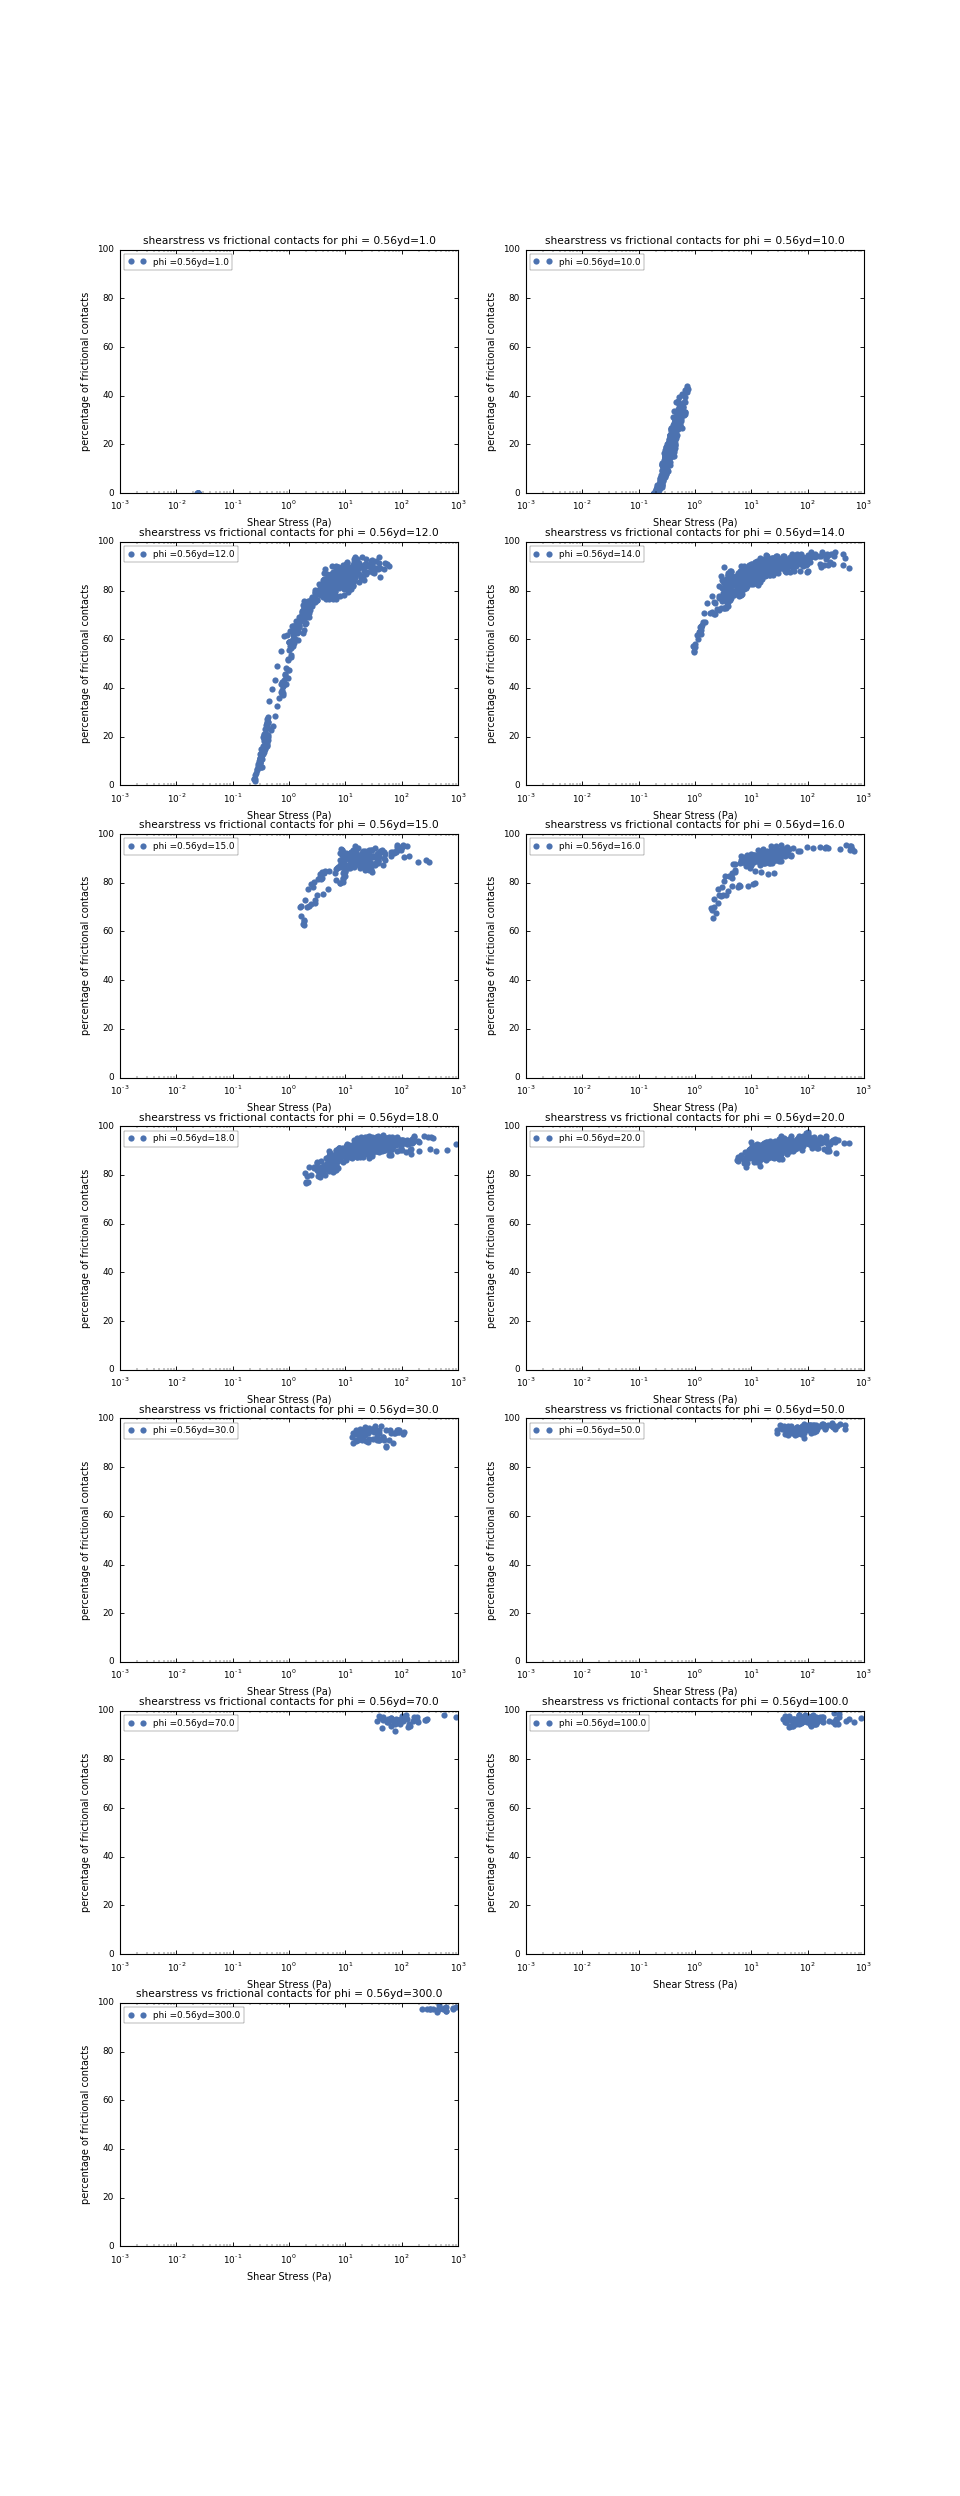

In [167]:
for i,p in enumerate(np.sort(db.keys())):
    plt.figure(figsize=[12,2.4*len(np.unique(db[p][0]))])
    for j,s in enumerate(np.unique(db[p][0])):
        plt.subplot(len(np.unique(db[p][0]))/2+1,2,j+1)
        idx = np.where(db[p][0]==s)[0]
        plt.plot(db[p][1][idx],db[p][2][idx],'o',label="phi ="+str(p)+"yd="+str(round(s)))
        plt.xlim([1e-3,1e3])
        plt.ylim([0,100.0])
        plt.xscale('log')
        plt.xlabel('Shear Stress (Pa)')
        plt.ylabel('percentage of frictional contacts')
        plt.title("shearstress vs frictional contacts for phi = "+str(p)+"yd="+str(round(s)))
        plt.legend(loc='upper left')
    plt.savefig('frictional_contact_vs_shearstress_individual_phi_individual_case_phi'+str(int(p*100)))